# Prediciendo ratings de libros en *Goodreads*

El objetivo de este análisis es entender cuales son los factores (variables) que influyen en que un libro sea más popular que otros. Además, proponer un modelo de ML para predecir el *rating* de un libro.

Las secciones de este análisis son:

1. Exploración de los datos
2. Liempieza de datos
3. Visualización de los datos
4. Preprocesamiento de los datos 
5. Modelos de *Machine Learning*



In [48]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from lightgbm.sklearn import LGBMRegressor
import multiprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error

In [3]:
%matplotlib inline
sns.set(style = 'darkgrid')
sns.set_palette('deep')

# Explorando los datos 

In [4]:
# read the data
data = pd.read_csv('/content/books.csv', error_bad_lines = False)
data.head()

<ipython-input-4-54736a3e796a>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('/content/books.csv', error_bad_lines = False)
Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


En el nombre de las columnas se observa que la columna 7 tiene un espacio al inicio. Vamos a quitar este espacio dado que puede traer problemas en el código cuando hagamos el análisis.

In [6]:
data = data.rename(columns = {'  num_pages': 'num_pages'})
data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [7]:
# check for doublications
data.duplicated().any()

False

Observe que no existen datos duplicados

In [8]:
data.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

No parecen haber datos faltantes. Sin embargo, con la visualización y estudio de la distribución de los datos nos daremos cuenta si hay valores inconsistentes en las variables.

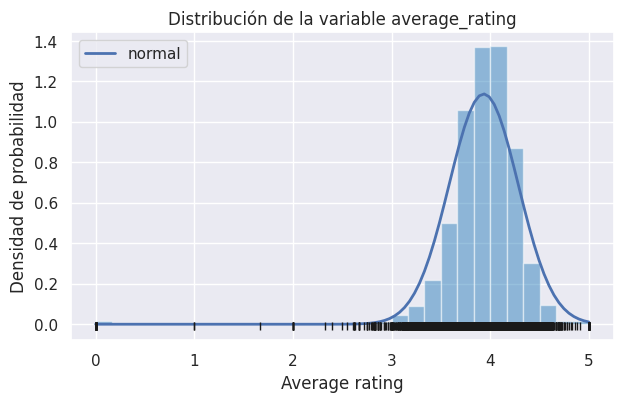

In [9]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
x = data['average_rating']
mu, sigma = stats.norm.fit(x)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(x), max(x), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución de la variable average_rating')
ax.set_xlabel('Average rating')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [10]:
x.describe()

count    11123.000000
mean         3.934075
std          0.350485
min          0.000000
25%          3.770000
50%          3.960000
75%          4.140000
max          5.000000
Name: average_rating, dtype: float64

La distribución de la variable `average_rating` parace cercana a la normal aunque un poco sesgada a la derecha debido a la existencia de algunos valores atípicos muy pequeños. Tanto el promedio como la media de los rating es cercana a 4 puntos.

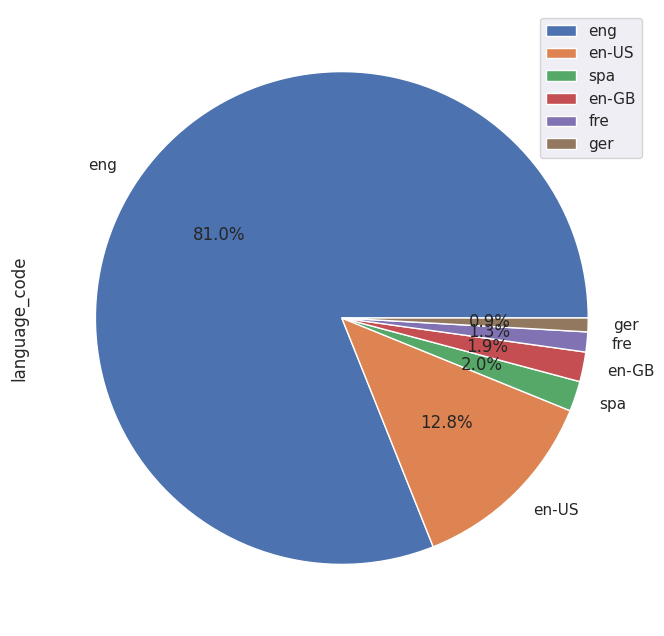

In [11]:
# top 5 languages
data['language_code'].value_counts().head(6).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

Casi el **96%** de los libros están en el idioma `Inglés`. Es lógico que esta variable no influya demasiado en el variable a predecir, dado que es casi constante.

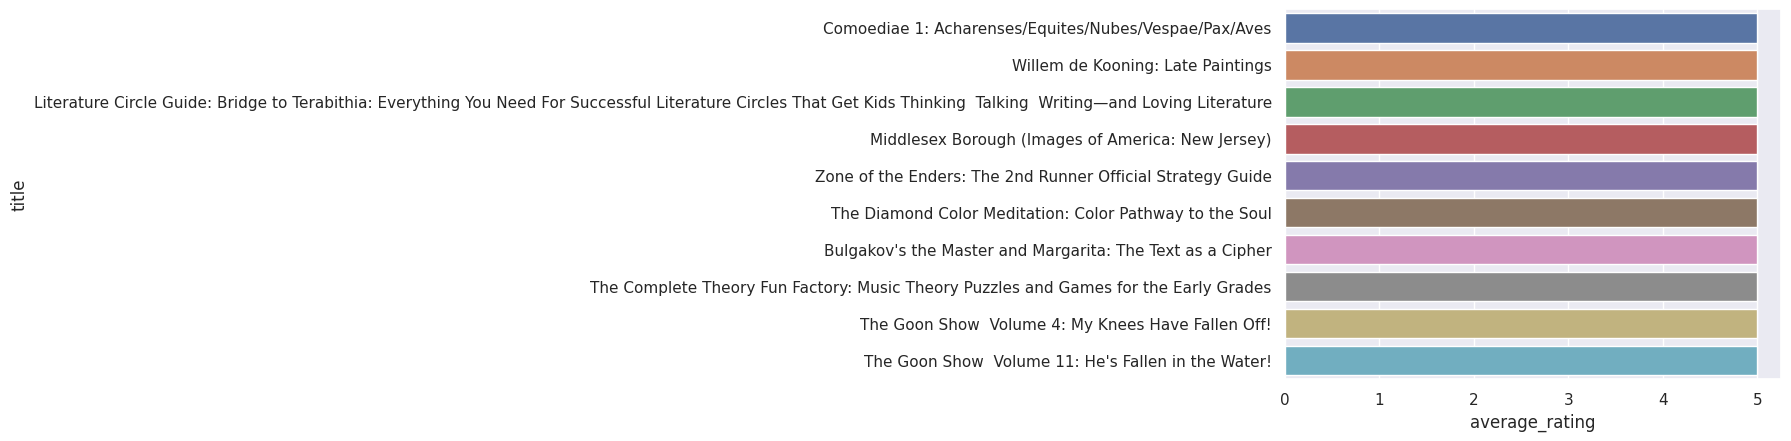

In [12]:
# libros mejor valorados
popular_books_rating_avg = data.nlargest(10, ['average_rating']).set_index('title')['average_rating']
sns.barplot(x = popular_books_rating_avg, y = popular_books_rating_avg.index)
plt.show()

En el gráfico de barras anterior se muestran los libros con mejores promedios de calificaciones. Note que todos tienen el máximo de rating, es decir, 5 puntos.

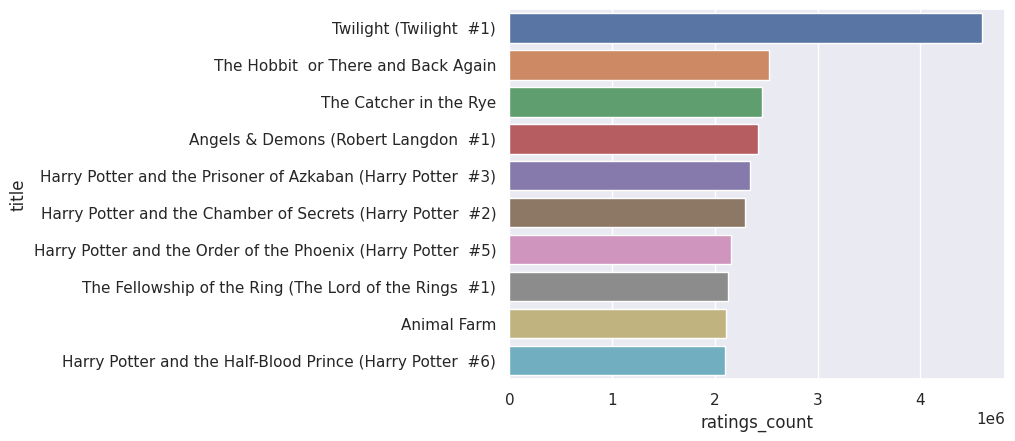

In [13]:
# libros más valorados
popular_books_ratings_count = data.nlargest(10, ['ratings_count']).set_index('title')['ratings_count']
sns.barplot(x = popular_books_ratings_count, y = popular_books_ratings_count.index)
plt.show()

En el gráfico de barras anterior se muestran los 10 libros que más calificaciones tienen. Note que ninguno entra en la lista de los 10 mejor valorados. Más adelante, profundizaremos en este tema. 

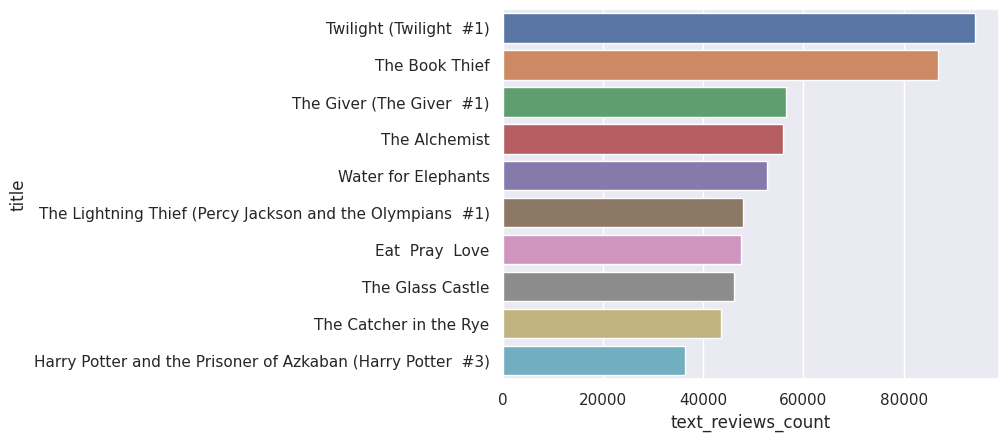

In [14]:
# libros con más revisiones del texto
popular_books_ratings_count = data.nlargest(10, ['text_reviews_count']).set_index('title')['text_reviews_count']
sns.barplot(x = popular_books_ratings_count, y = popular_books_ratings_count.index)
plt.show()

En el gráfico de barras anterior se muestran los 10 libros con más revisiones del texto. Aunque no coinciden exactamente con los que más calificaciones tienen, existen algunas coincidencias.

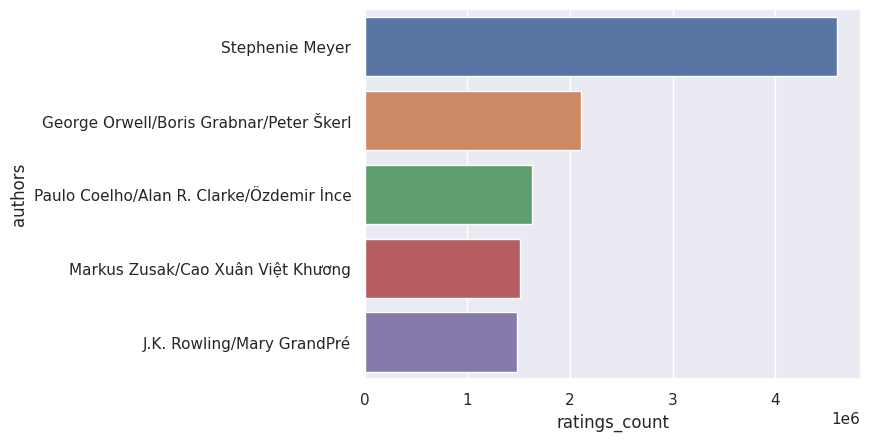

In [15]:
popular_authors_ratings_count = data.groupby('authors')['ratings_count'].mean().sort_values(ascending = False).head()
sns.barplot(x = popular_authors_ratings_count, y = popular_authors_ratings_count.index)
plt.show()

Arriba se muestran los cinco autores que más calificaciones tienen. 

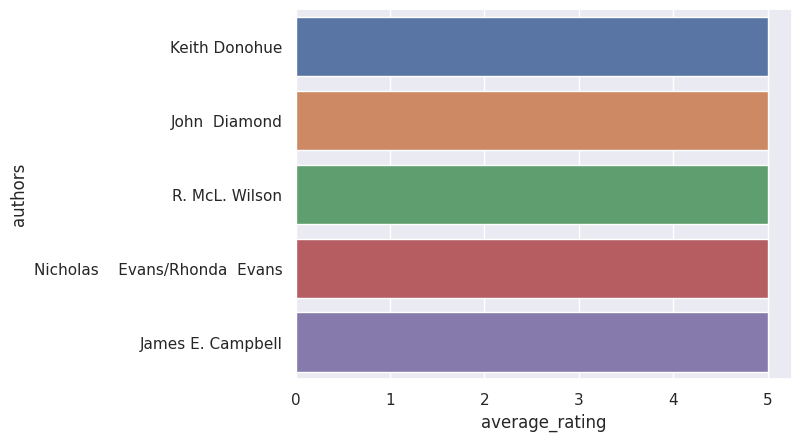

In [16]:
popular_authors_ave_rating = data.groupby('authors')['average_rating'].mean().sort_values(ascending = False).head()
sns.barplot(x = popular_authors_ave_rating, y = popular_authors_ave_rating.index)
plt.show()

Nótese que, de nuevo, existe una discordancia entre los libros que más rating tienen y los que más calificaciones tienen. En ese sentido, creemos que es necesario definir una **nueva variable** que describa de manera más "justa" la calificación de un libro.

Por ejemplo, un libro puede tener una calificación promedio muy alta, pero pocas calificaciones. Sin embargo, otro libro puede tener una calificación promedio menor pero muchas calificaciones. Este segundo escenario sería más verosimil para decir que el segundo libro es más popular que el primero. Vamos a definir la **calificacion promedio ponderada**. 

In [17]:
def weighted_average_rating(row):
  rating_total_count = data['ratings_count'].sum()
  rating_total_review = data['text_reviews_count'].sum()
  row_rate_rating_count =row['ratings_count']/rating_total_count

  return row['average_rating']*row_rate_rating_count

In [18]:
data['weighted_average_rating'] = data.apply(weighted_average_rating, axis = 1)

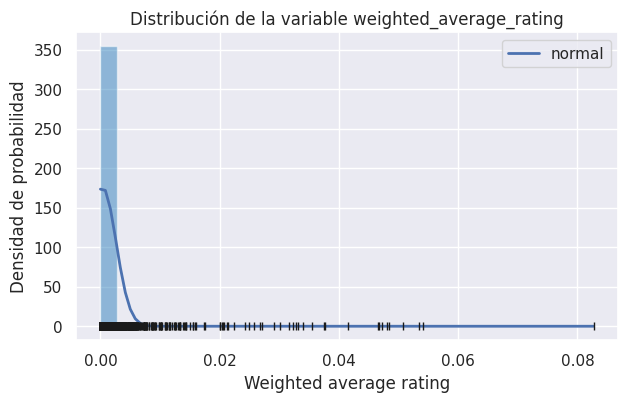

In [20]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
x = data['weighted_average_rating']
mu, sigma = stats.norm.fit(x)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(x), max(x), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución de la variable weighted_average_rating')
ax.set_xlabel('Weighted average rating' )
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

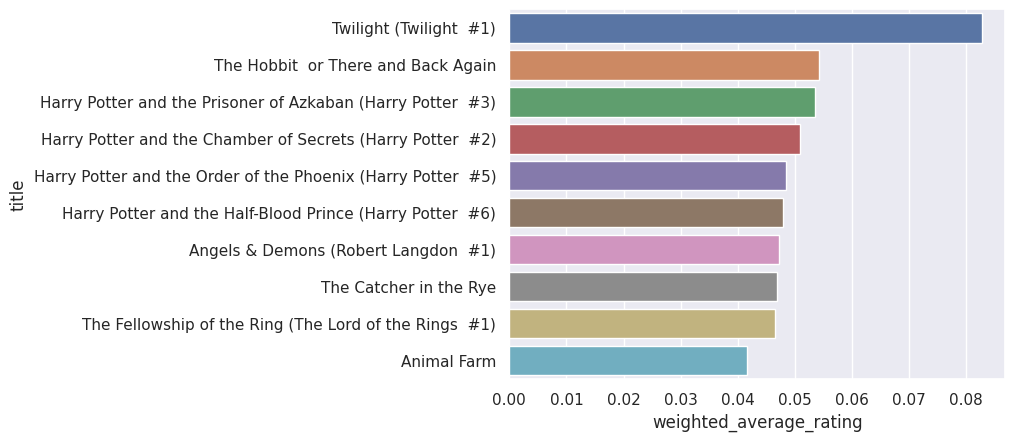

In [21]:
# libros mejor valorados
popular_books_rating_avg = data.nlargest(10, ['weighted_average_rating']).set_index('title')['weighted_average_rating']
sns.barplot(x = popular_books_rating_avg, y = popular_books_rating_avg.index)
plt.show()

Note que hay mucho más concordancia entre la variable `weighted_average_rating` y la variable `ratings_count` en cuanto a su distribución y en cuanto top 10 de libros con respecto a ambas variables. 

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bookID                   11123 non-null  int64  
 1   title                    11123 non-null  object 
 2   authors                  11123 non-null  object 
 3   average_rating           11123 non-null  float64
 4   isbn                     11123 non-null  object 
 5   isbn13                   11123 non-null  int64  
 6   language_code            11123 non-null  object 
 7   num_pages                11123 non-null  int64  
 8   ratings_count            11123 non-null  int64  
 9   text_reviews_count       11123 non-null  int64  
 10  publication_date         11123 non-null  object 
 11  publisher                11123 non-null  object 
 12  weighted_average_rating  11123 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.1+ MB


In [23]:
data['publication_date'] = pd.to_datetime(data['publication_date'], format = '%m/%d/%Y', errors='coerce')

In [24]:
data['publication_date'].isna().sum()

2

Hemos convertido la columna `publication_date` al formato `date` y han aparecido dos observaciones que complían con el formato general en el que están dadas las fechas de publicación. En ese sentido, los valores de esta columna han quedado como `nan`.

In [25]:
data.corr()

<ipython-input-25-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,weighted_average_rating
bookID,1.000000,-0.036207,-0.002185,-0.026134,-0.076820,-0.081289,-0.077622
average_rating,-0.036207,1.000000,-0.001965,0.150477,0.038224,0.033663,0.044985
isbn13,-0.002185,-0.001965,1.000000,-0.009818,0.005494,0.008152,0.005294
num_pages,-0.026134,0.150477,-0.009818,1.000000,0.034337,0.036977,0.036182
ratings_count,-0.076820,0.038224,0.005494,0.034337,1.000000,0.865977,0.997043
text_reviews_count,-0.081289,0.033663,0.008152,0.036977,0.865977,1.000000,0.861244
weighted_average_rating,-0.077622,0.044985,0.005294,0.036182,0.997043,0.861244,1.000000


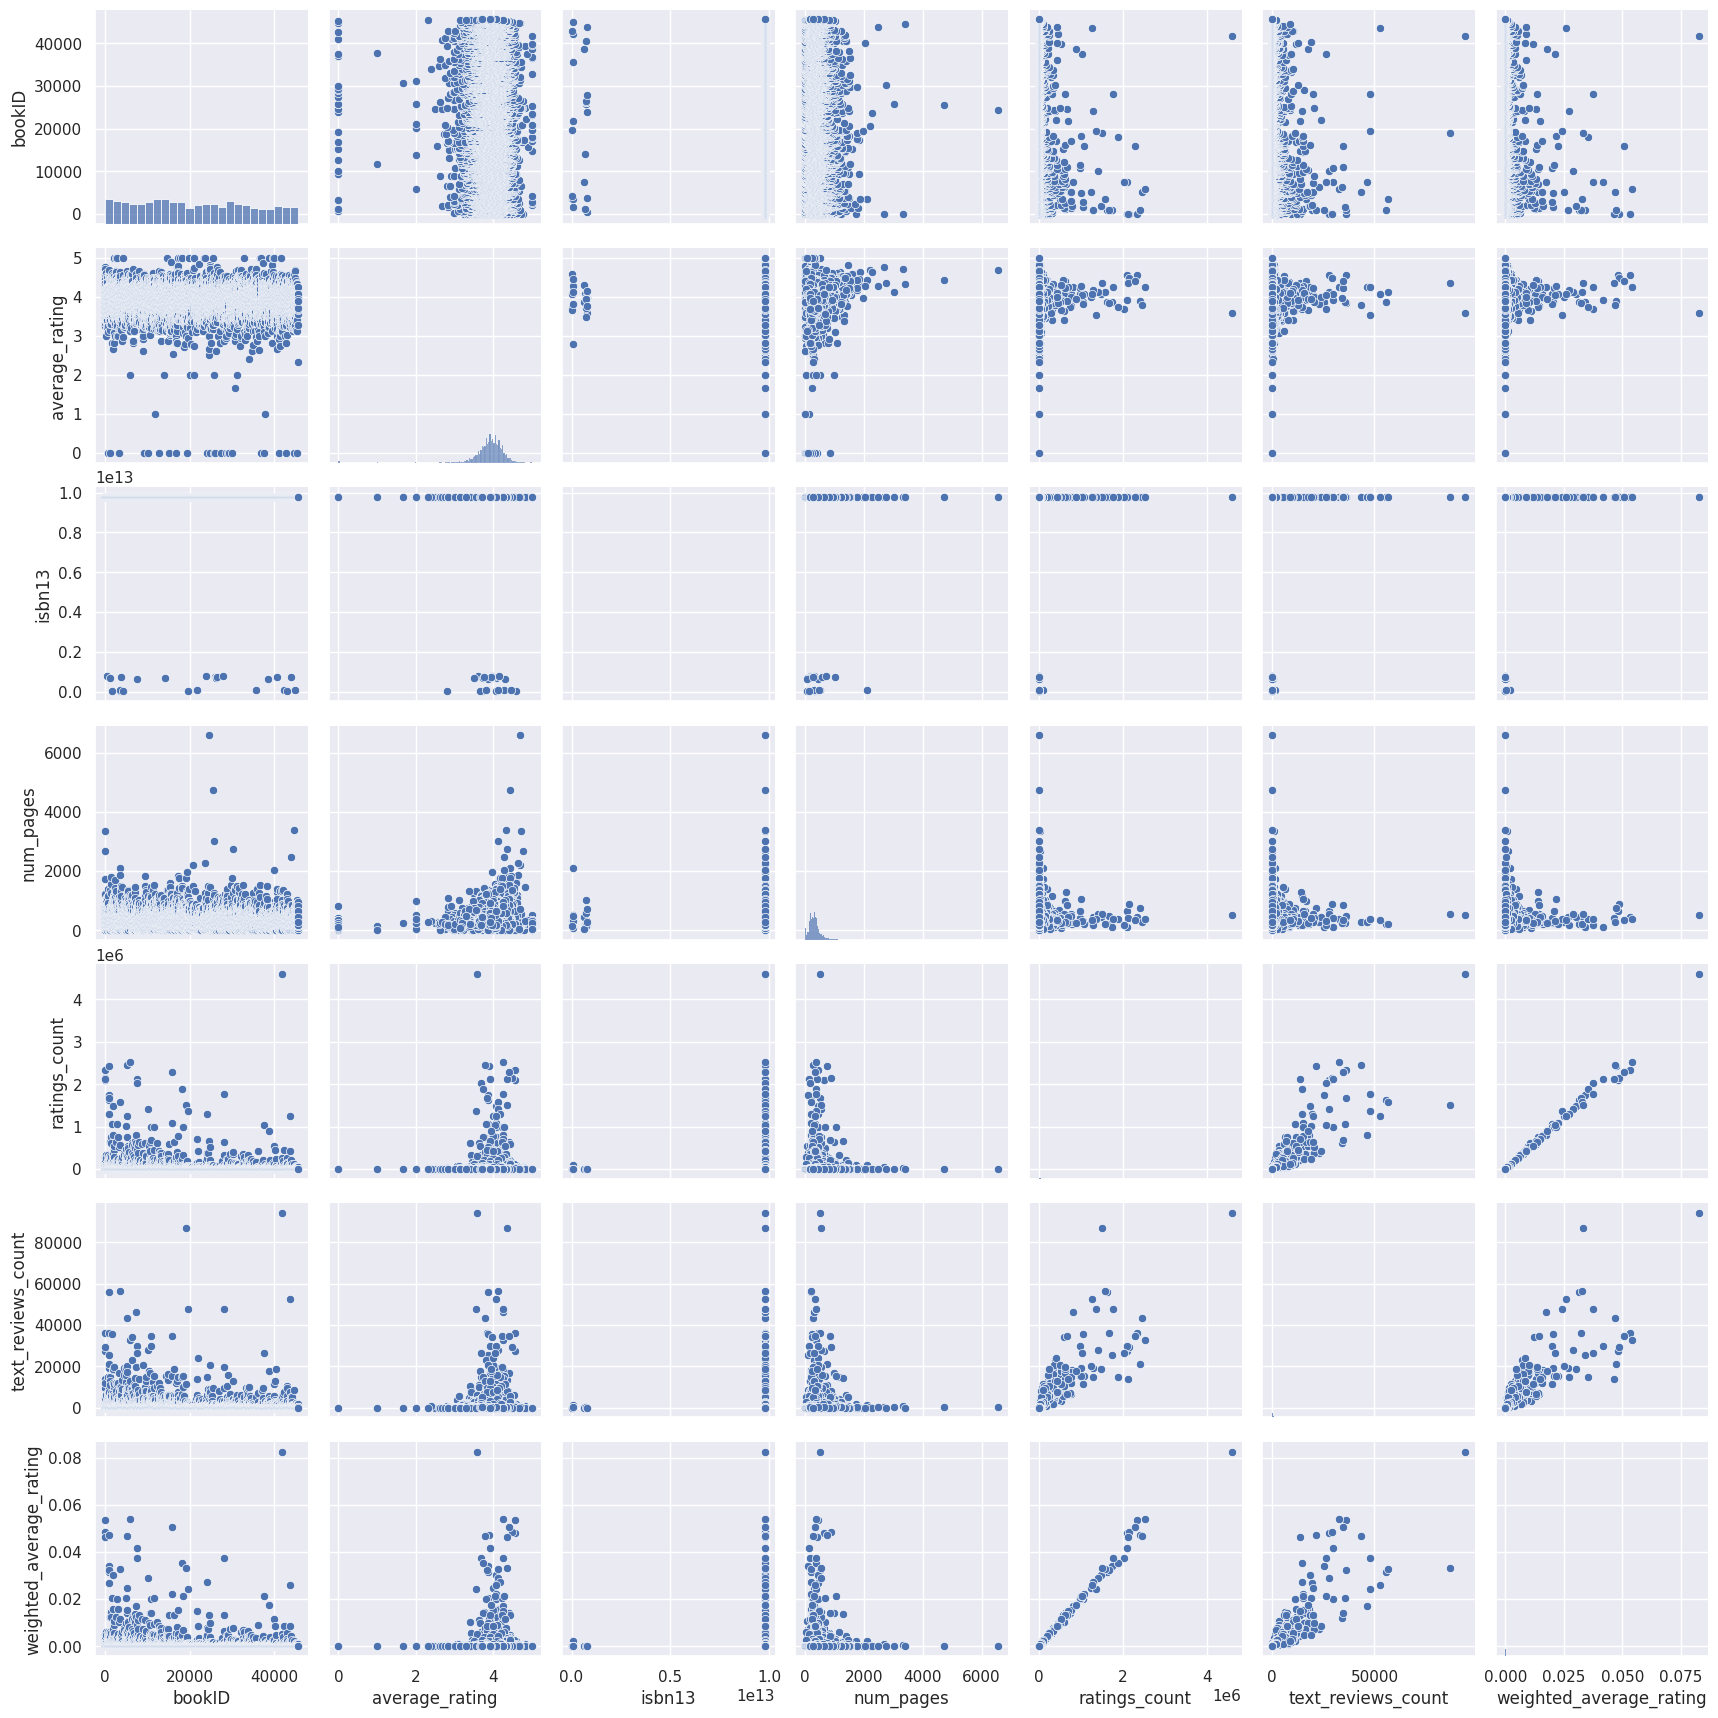

In [ ]:
sns.pairplot(data, diag_kind='hist')

Los diagramas de dispersión anteriores muestran situaciones interesantes. 

* Lógicamente, las variables `weighted_average_rating`, `text_reviews_count` y `ratings_count` tienen alta correlación. Eso es importante, porque nosotros hemos querido que las dos variables orginales tengan impacto en la variable objetivo `weighted_average_rating`.

* Encontramos una alta dispersión de la variable `weighted_average_rating` en torno a valores altos de la variable `average_rating`. Un libro puede tener un `average_rating` alto y sin embargo presentar un `weighted_average_rating` bajo porque tiene pocas calificaciones.

* En lo adelante, la variable objetivo será `weighted_average_rating`.

* Los libros de mál alto `weighted_average_rating` son los que tienen menos páginas. Los libros de muchas páginas son pocos y con bajas calificaciones.

In [26]:
data_series_time = data[['weighted_average_rating', 'publication_date']].dropna(subset = ['publication_date']).set_index(['publication_date']).sort_index()

In [27]:
data_series_time.head(10)

,weighted_average_rating
publication_date,
1900-01-01,6.454409e-06
1913-01-01,2.202444e-06
1914-01-01,1.721881e-06
1919-01-01,4.502293e-06
1921-01-01,4.135219e-07
1921-01-01,8.282464e-07
1922-02-22,0.000000e+00
1923-01-01,7.523363e-07
1925-01-01,3.808029e-07


Text(0, 0.5, 'Weighted Average Rating')

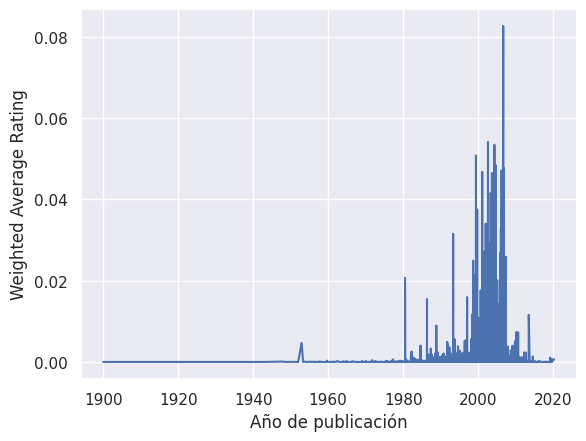

In [29]:
plt.plot(data_series_time)
plt.xlabel('Año de publicación')
plt.ylabel('Weighted Average Rating')

Se puede observar que la mayor variabilidad de la variable objetivo se ve a la escala de años. 

In [30]:
data = data .dropna(subset = ['publication_date'])
data['publication_day'] = data['publication_date'].dt.day.astype(int)
data['publication_month'] = data['publication_date'].dt.month.astype(int)
data['publication_year'] = data['publication_date'].dt.year.astype(int)


<ipython-input-30-bd44bc48f65f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['publication_day'] = data['publication_date'].dt.day.astype(int)
<ipython-input-30-bd44bc48f65f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['publication_month'] = data['publication_date'].dt.month.astype(int)
<ipython-input-30-bd44bc48f65f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [31]:
data.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,weighted_average_rating,publication_day,publication_month,publication_year
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,0.047988,16,9,2006
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,0.048441,1,9,2004
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,0.000140,1,11,2003
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,0.053455,1,5,2004
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,0.000992,13,9,2004


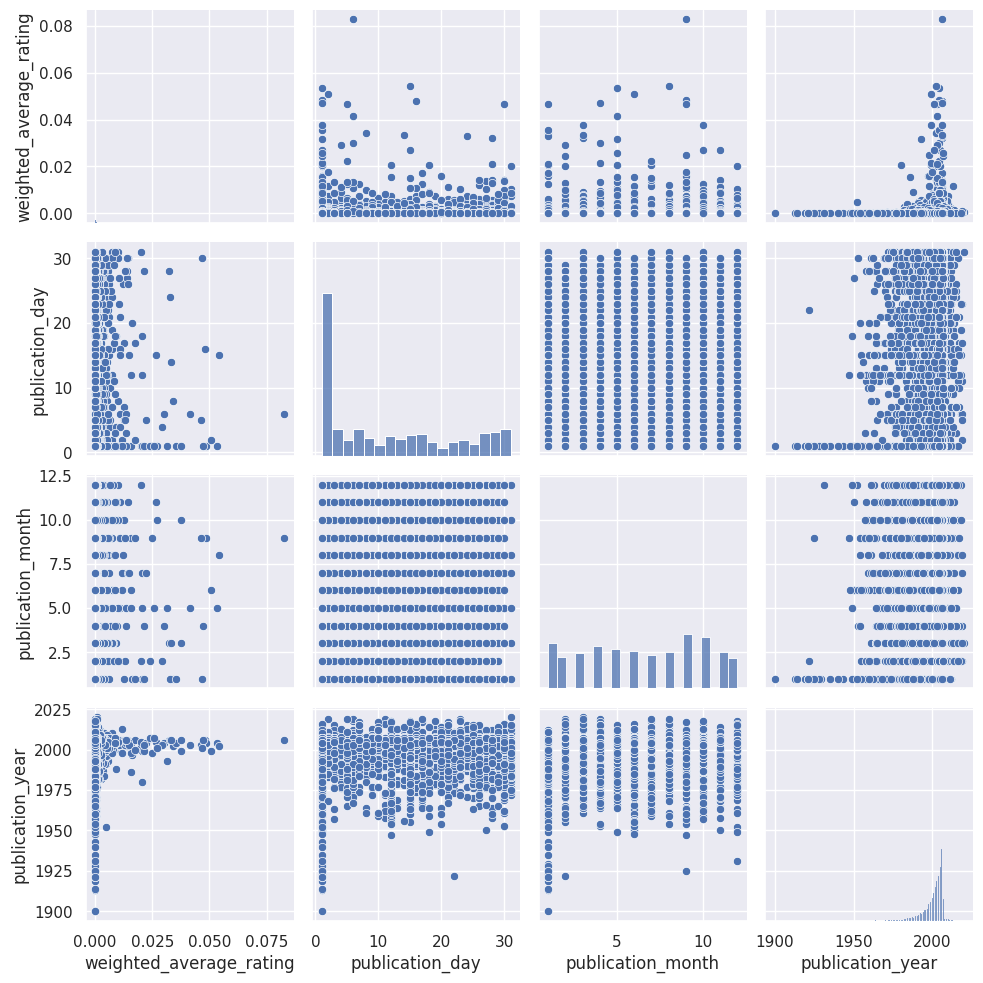

In [ ]:
sns.pairplot(data[['weighted_average_rating', 'publication_day', 'publication_month', 'publication_year']], diag_kind='hist')

In [32]:
data[['weighted_average_rating', 'publication_day', 'publication_month', 'publication_year']].corr()

,weighted_average_rating,publication_day,publication_month,publication_year
weighted_average_rating,1.000000,-0.002715,-0.015358,0.044090
publication_day,-0.002715,1.000000,0.040826,0.056469
publication_month,-0.015358,0.040826,1.000000,0.022686
publication_year,0.044090,0.056469,0.022686,1.000000


Note que la variable relacionada con la fecha de lanzamiento que mayor correlación lineal tiene con `weighted_average_rating`. 

# Buscando el mejor modelo para predecir la variable `weighted_average_rating`

## Regesión Lineal

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11121 entries, 0 to 11122
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookID                   11121 non-null  int64         
 1   title                    11121 non-null  object        
 2   authors                  11121 non-null  object        
 3   average_rating           11121 non-null  float64       
 4   isbn                     11121 non-null  object        
 5   isbn13                   11121 non-null  int64         
 6   language_code            11121 non-null  object        
 7   num_pages                11121 non-null  int64         
 8   ratings_count            11121 non-null  int64         
 9   text_reviews_count       11121 non-null  int64         
 10  publication_date         11121 non-null  datetime64[ns]
 11  publisher                11121 non-null  object        
 12  weighted_average_rating  11121 n

In [34]:
X = data [['authors', 'language_code', 'num_pages', 'publication_day', 'publication_month', 'publication_year']] # predictors
y = data['weighted_average_rating'] # target

In [35]:
le = LabelEncoder()

enc_lenguage = pd.get_dummies(X['language_code'], drop_first=True)
X['authors'] = le.fit_transform(X['authors'])

X = X.drop(['authors', 'language_code'], axis = 1)
X = pd.concat([X, enc_lenguage], axis = 1)

<ipython-input-35-28c6c2bbca1f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['authors'] = le.fit_transform(X['authors'])


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 123)

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
pred = lr.predict(X_test)
print('porcentaje de RMSE:', mean_squared_error(y_test, pred, squared = False)/max(y_test)*100)

porcentaje de RMSE: 4.16707912718809


## Light GBM

Ahora vamos a buscar optimizar los parámetros en un modelo de tipo Gradient Boosting llamado `Light GBM``.  

In [39]:
X = data [['authors', 'language_code', 'num_pages', 'publication_day', 'publication_month', 'publication_year']] # predictors
y = data['weighted_average_rating'] # target

In [44]:
cat_cols = list(X.select_dtypes(['object']))
X[cat_cols] = X[cat_cols].astype('category')

<ipython-input-44-6a44aff25d29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].astype('category')


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 123)

In [49]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators'     : [100, 500, 1000, 5000],
              'max_depth'        : [-1, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = LGBMRegressor(random_state=123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=123),
             estimator=LGBMRegressor(random_state=123), n_jobs=1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [-1, 1, 3, 5, 10, 20],
                         'n_estimators': [100, 500, 1000, 5000],
                         'subsample': [0.5, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [52]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test,)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )/max(y_test)*100
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 4.16334337932303


# Conclusiones

Hemos entrenado dos tipos de modelos: `LinearRegression` y `LGBMRegressor`. Encontramos que ambos tienen métricas `RSME` muy parecidas, sin embargo, el modelo `LinearRegression` es mucho más rápido de entrenar. 